In [1]:
import numpy as np
import pandas as pd
import joblib

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**A. Loading the tfidf tweets**

In [3]:
tweets = joblib.load('./vectors/tfidf_tweets.sav')
tweets = tweets.toarray()
tweets

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**B. Loading our target labels**

In [4]:
tweets_train_y = pd.read_csv('csvs/tweets_train_y.csv', index_col=False)
tweets_train_y = pd.Series(tweets_train_y['0'])
tweets_train_y = tweets_train_y.values
tweets_train_y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [5]:
unique_elements, counts_elements = np.unique(tweets_train_y, return_counts=True)
print("Frequency of unique values of our target labels:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of our target labels:
[[    0     1     2]
 [ 7748 22256 19671]]


**C. Combining our inputs and targets**

In [6]:
data = np.column_stack([tweets,tweets_train_y])
data

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

**D. Separating the minority class from the dataset**

In [7]:
df_train_negative = data[data[:,-1] == 0]
df_train_negative

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
len(df_train_negative)

7748

In [9]:
df_train_neutral = data[data[:,-1] == 1]
df_train_neutral
len(df_train_neutral)

22256

In [10]:
df_train_positive = data[data[:,-1] == 2]
df_train_positive
len(df_train_positive)

19671

We will increase the population of our negative class so that its final population is equal to the average of the population of neutral and the positive class.

In [11]:
ave_pos_neutral = int(np.round(np.mean([len(df_train_neutral), len(df_train_positive)]),0))
ave_pos_neutral

20964

In [12]:
X_train = data[:,:-1]
X_train = torch.from_numpy(X_train).type(torch.float)

y_train = data[:,-1]
y_train = torch.from_numpy(y_train).type(torch.float)

X_train_negative = df_train_negative[:,:-1]
X_train_negative = torch.from_numpy(X_train_negative).type(torch.float)
X_train_negative.shape

torch.Size([7748, 5000])

**F. Applying Variational Autoencoder on the `Negative` class**

In [13]:
# Source: https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features=50, num_dim=5000):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_features = num_features
        self.num_dim = num_dim
        
        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=500)
        self.encoder_layer_2 = nn.Linear(in_features=500, out_features=(self.num_features * 2))
        
        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=500)
        self.decoder_layer_2 = nn.Linear(in_features=500, out_features=self.num_dim)
        
        self.relu = nn.ReLU() # hidden layers
        self.sigmoid = nn.Sigmoid() # output layer
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)    # sampling as if coming from the input space
        
        return sample
    
    def encode(self, x):
        # encoding
        #x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var
    
    def decode(self, z, mu, log_var):
        # decoding
        #x = F.relu(self.decoder_layer_1(z))
        x = self.decoder_layer_1(z)
        x = self.relu(x)
        
        #reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        reconstruction = self.decoder_layer_2(x)
        reconstruction = self.sigmoid(reconstruction)
        
        return reconstruction, mu, log_var
    
    # Utility function to generate new data based on:
    # mu: The average that you want to have (should be the same size as num_features)
    # log_var: The variance that you want to have (should be the same size as num_features)
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction
        
    
    def forward(self, x):
        
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction, mu, log_var

In [14]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

In [15]:
# The final loss is a combination of the reconstruction loss (first argument) and the loss from an assumed distribution (i.e. Normal / Gaussian distribution)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [16]:
num_features = 50
model = VariationalAutoencoder(num_features=num_features)
learning_rate = 0.0001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 128

In [17]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        reconstruction, mu, logvar = model.forward(data)
        
        loss = loss_fn(reconstruction, targets)
        
        loss = final_loss(loss, mu, logvar)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

In [18]:
# use Dataloader for Autoencoder 
custom_dataset = AutoencoderDataset(X_train_negative)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [19]:
import time

epochs = 50
losses = []

start = time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model.state_dict() }

    torch.save(state, "./torch_models/variational-autoencoder.pth")

end = time.time()    
print(f'Training duration: {(end-start)} seconds')

Epoch: 0


100%|██████████| 61/61 [00:06<00:00,  9.97it/s, loss=0.494]


Ave Loss: 2.1239683334944677
Epoch: 1


100%|██████████| 61/61 [00:05<00:00, 11.74it/s, loss=0.266]


Ave Loss: 0.3918925352761003
Epoch: 2


100%|██████████| 61/61 [00:05<00:00, 11.57it/s, loss=0.163]


Ave Loss: 0.2259629766960613
Epoch: 3


100%|██████████| 61/61 [00:05<00:00, 11.77it/s, loss=0.104]


Ave Loss: 0.1438758919229273
Epoch: 4


100%|██████████| 61/61 [00:05<00:00, 11.40it/s, loss=0.0789]


Ave Loss: 0.09872645823681941
Epoch: 5


100%|██████████| 61/61 [00:05<00:00, 11.29it/s, loss=0.0559]


Ave Loss: 0.07187488943826957
Epoch: 6


100%|██████████| 61/61 [00:05<00:00, 11.20it/s, loss=0.0432]


Ave Loss: 0.05470408279387677
Epoch: 7


100%|██████████| 61/61 [00:05<00:00, 11.44it/s, loss=0.0322]


Ave Loss: 0.043039463399375075
Epoch: 8


100%|██████████| 61/61 [00:05<00:00, 11.15it/s, loss=0.0287]


Ave Loss: 0.035127202384784575
Epoch: 9


100%|██████████| 61/61 [00:05<00:00, 11.33it/s, loss=0.0239]


Ave Loss: 0.02900214413883256
Epoch: 10


100%|██████████| 61/61 [00:05<00:00, 11.18it/s, loss=0.019] 


Ave Loss: 0.024688738474591833
Epoch: 11


100%|██████████| 61/61 [00:05<00:00, 11.22it/s, loss=0.0172]


Ave Loss: 0.021423947615701645
Epoch: 12


100%|██████████| 61/61 [00:05<00:00, 10.91it/s, loss=0.0145]


Ave Loss: 0.018647538879733593
Epoch: 13


100%|██████████| 61/61 [00:05<00:00, 11.17it/s, loss=0.0134]


Ave Loss: 0.01645252923862856
Epoch: 14


100%|██████████| 61/61 [00:05<00:00, 11.08it/s, loss=0.0118]


Ave Loss: 0.014764037319138402
Epoch: 15


100%|██████████| 61/61 [00:05<00:00, 10.88it/s, loss=0.0111]


Ave Loss: 0.01343223197599415
Epoch: 16


100%|██████████| 61/61 [00:05<00:00, 10.97it/s, loss=0.0105]


Ave Loss: 0.012185667870474643
Epoch: 17


100%|██████████| 61/61 [00:05<00:00, 11.16it/s, loss=0.00994]


Ave Loss: 0.01133646377835606
Epoch: 18


100%|██████████| 61/61 [00:05<00:00, 11.13it/s, loss=0.00931]


Ave Loss: 0.010440333914317068
Epoch: 19


100%|██████████| 61/61 [00:05<00:00, 11.17it/s, loss=0.00857]


Ave Loss: 0.009788791618508394
Epoch: 20


100%|██████████| 61/61 [00:05<00:00, 11.26it/s, loss=0.00795]


Ave Loss: 0.00919835535107089
Epoch: 21


100%|██████████| 61/61 [00:05<00:00, 11.23it/s, loss=0.00776]


Ave Loss: 0.008677567034715512
Epoch: 22


100%|██████████| 61/61 [00:05<00:00, 11.29it/s, loss=0.00726]


Ave Loss: 0.008223015402794862
Epoch: 23


100%|██████████| 61/61 [00:05<00:00, 11.37it/s, loss=0.00668]


Ave Loss: 0.007903115159725069
Epoch: 24


100%|██████████| 61/61 [00:05<00:00, 11.18it/s, loss=0.00663]


Ave Loss: 0.0075437330457641455
Epoch: 25


100%|██████████| 61/61 [00:05<00:00, 11.47it/s, loss=0.00611]


Ave Loss: 0.0072513707821852845
Epoch: 26


100%|██████████| 61/61 [00:05<00:00, 11.21it/s, loss=0.00638]


Ave Loss: 0.007018908255229719
Epoch: 27


100%|██████████| 61/61 [00:05<00:00, 11.27it/s, loss=0.00613]


Ave Loss: 0.006753015309022587
Epoch: 28


100%|██████████| 61/61 [00:05<00:00, 11.16it/s, loss=0.00608]


Ave Loss: 0.006592236505057968
Epoch: 29


100%|██████████| 61/61 [00:05<00:00, 11.46it/s, loss=0.00591]


Ave Loss: 0.006380515799048494
Epoch: 30


100%|██████████| 61/61 [00:05<00:00, 11.96it/s, loss=0.00583]


Ave Loss: 0.006281575516293772
Epoch: 31


100%|██████████| 61/61 [00:05<00:00, 11.73it/s, loss=0.00587]


Ave Loss: 0.006135182707097198
Epoch: 32


100%|██████████| 61/61 [00:05<00:00, 11.78it/s, loss=0.00557]


Ave Loss: 0.006007760160098799
Epoch: 33


100%|██████████| 61/61 [00:05<00:00, 11.78it/s, loss=0.00551]


Ave Loss: 0.005907212903142952
Epoch: 34


100%|██████████| 61/61 [00:05<00:00, 11.59it/s, loss=0.00544]


Ave Loss: 0.005827954901596074
Epoch: 35


100%|██████████| 61/61 [00:05<00:00, 11.60it/s, loss=0.0055] 


Ave Loss: 0.005780000209075506
Epoch: 36


100%|██████████| 61/61 [00:05<00:00, 10.85it/s, loss=0.00538]


Ave Loss: 0.0057374356146596495
Epoch: 37


100%|██████████| 61/61 [00:05<00:00, 11.54it/s, loss=0.00533]


Ave Loss: 0.005695667965184959
Epoch: 38


100%|██████████| 61/61 [00:05<00:00, 11.46it/s, loss=0.00537]


Ave Loss: 0.0057023155625115654
Epoch: 39


100%|██████████| 61/61 [00:05<00:00, 11.55it/s, loss=0.00526]


Ave Loss: 0.00568319048701984
Epoch: 40


100%|██████████| 61/61 [00:05<00:00, 11.58it/s, loss=0.0053] 


Ave Loss: 0.005709928414616428
Epoch: 41


100%|██████████| 61/61 [00:05<00:00, 10.90it/s, loss=0.00523]


Ave Loss: 0.0057296947515035265
Epoch: 42


100%|██████████| 61/61 [00:05<00:00, 11.20it/s, loss=0.00524]


Ave Loss: 0.005833928572533072
Epoch: 43


100%|██████████| 61/61 [00:06<00:00,  9.61it/s, loss=0.00533]


Ave Loss: 0.005989892835744092
Epoch: 44


100%|██████████| 61/61 [00:08<00:00,  7.24it/s, loss=0.00556]


Ave Loss: 0.006405923477389285
Epoch: 45


100%|██████████| 61/61 [00:06<00:00,  9.59it/s, loss=0.00677]


Ave Loss: 0.0071659169358308196
Epoch: 46


100%|██████████| 61/61 [00:06<00:00,  9.55it/s, loss=0.00956]


Ave Loss: 0.00885129626840353
Epoch: 47


100%|██████████| 61/61 [00:05<00:00, 11.74it/s, loss=0.0115] 


Ave Loss: 0.012868481779806927
Epoch: 48


100%|██████████| 61/61 [00:05<00:00, 11.31it/s, loss=0.0125]


Ave Loss: 0.023927652002235907
Epoch: 49


100%|██████████| 61/61 [00:05<00:00, 11.44it/s, loss=0.0349]

Ave Loss: 0.03855347105103438
Training duration: 276.95382285118103 seconds


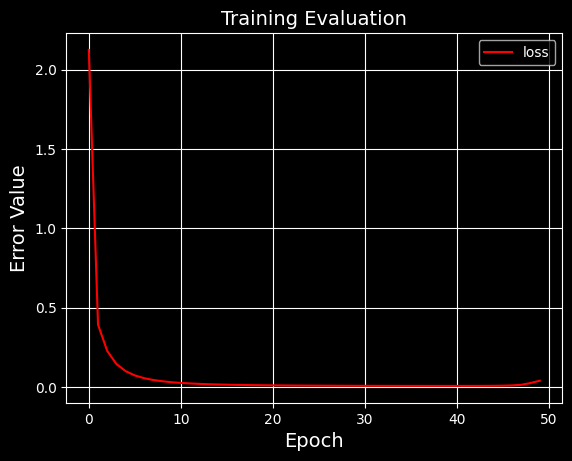

In [20]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [21]:
import random

# Create a vector of zero tensors representing 0 average per num_feature (right in the middle of the dist)
sampled_mu = torch.Tensor([np.zeros(num_features)])

# Create a vector of zero tensors representing 0 standard deviations away from the mean to create variations
# Change this is you want to sample away from the mean to create "off-quality" data
sampled_logvar = torch.Tensor([np.zeros(num_features)])

X_train_negative_copy = X_train_negative.detach().cpu().numpy().copy()
added_data_to_minority = []

for i in range(ave_pos_neutral-len(X_train_negative)):
    reconstruction = model.sample(sampled_mu, sampled_logvar)
    reconstruction = reconstruction[0].detach().cpu().numpy()
    added_data_to_minority.append(reconstruction)

added_data_to_minority

C:\Users\acer\AppData\Local\Temp\ipykernel_42976\1927566234.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  sampled_mu = torch.Tensor([np.zeros(num_features)])


[array([0.00160628, 0.00199182, 0.00092132, ..., 0.00149369, 0.00095964,
        0.00099544], dtype=float32),
 array([0.00144061, 0.00136237, 0.00177259, ..., 0.00135526, 0.0017693 ,
        0.00182035], dtype=float32),
 array([0.00047823, 0.00062434, 0.00047382, ..., 0.00029856, 0.00021988,
        0.00042765], dtype=float32),
 array([0.00146289, 0.0023705 , 0.00262357, ..., 0.00207691, 0.00131973,
        0.00163266], dtype=float32),
 array([0.00013732, 0.00044289, 0.00047178, ..., 0.00060729, 0.00045818,
        0.0007895 ], dtype=float32),
 array([0.00024868, 0.00028967, 0.0002704 , ..., 0.00027152, 0.00041861,
        0.00026692], dtype=float32),
 array([0.00022495, 0.00052319, 0.00045392, ..., 0.00043933, 0.00027076,
        0.00037458], dtype=float32),
 array([0.00020036, 0.00030118, 0.00040356, ..., 0.00030997, 0.00031457,
        0.00060613], dtype=float32),
 array([0.00065789, 0.00091131, 0.00144289, ..., 0.00159309, 0.00088915,
        0.00084359], dtype=float32),
 array([0.

In [22]:
X_negative = np.concatenate((X_train_negative_copy, added_data_to_minority))
X_negative.shape

(20964, 5000)

In [23]:
X_negative = pd.DataFrame(X_negative)
X_negative[5000] = 0
X_negative

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20959,0.000234,0.000146,0.000485,0.000268,0.000239,0.000462,0.000248,0.000255,0.000762,0.000265,...,0.000271,0.000093,0.000904,0.000168,0.000228,0.000214,0.000206,0.000127,0.000310,0
20960,0.000069,0.000121,0.000078,0.000069,0.000118,0.000092,0.000062,0.000046,0.000274,0.000038,...,0.000091,0.000074,0.000420,0.000060,0.000069,0.000125,0.000104,0.000121,0.000164,0
20961,0.000534,0.001034,0.000848,0.000610,0.000414,0.000636,0.000516,0.000903,0.001817,0.000889,...,0.000440,0.000443,0.001707,0.000929,0.000661,0.000490,0.000531,0.000725,0.001043,0
20962,0.000149,0.000230,0.000359,0.000279,0.000171,0.000205,0.000077,0.000099,0.000873,0.000212,...,0.000213,0.000170,0.001101,0.000278,0.000259,0.000260,0.000110,0.000192,0.000171,0


In [24]:
df_train_neutral = pd.DataFrame(df_train_neutral)
df_train_neutral

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
df_train_positive = pd.DataFrame(df_train_positive)
df_train_positive

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.623108,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
19667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.481976,2.0
19668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
19669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0


In [26]:
df_balanced = pd.concat([X_negative, df_train_neutral, df_train_positive], ignore_index=True)
df_balanced = df_balanced.sample(frac = 1)
df_balanced

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
36871,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
47556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
23162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
53730,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
16794,0.000630,0.000832,0.000799,0.001351,0.000495,0.001015,0.000654,0.000428,0.001269,0.002028,...,0.000657,0.000408,0.001400,0.000443,0.001044,0.000581,0.000403,0.000409,0.000782,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
47435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
13251,0.000741,0.002118,0.001383,0.000660,0.001682,0.000816,0.000709,0.001345,0.002330,0.001308,...,0.000871,0.000722,0.004126,0.000662,0.000745,0.001195,0.000841,0.001208,0.001123,0.0
42972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


In [27]:
df_balanced.iloc[:,-1].value_counts(normalize=True)

1.0    0.353882
0.0    0.333339
2.0    0.312779
Name: 5000, dtype: float64

In [28]:
df_inputs = df_balanced.iloc[:,:-1].values
df_inputs = torch.from_numpy(df_inputs).type(torch.float)
df_inputs

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0007, 0.0021, 0.0014,  ..., 0.0008, 0.0012, 0.0011],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [29]:
df_targets = df_balanced.iloc[:,-1].values
df_targets = torch.from_numpy(df_targets).type(torch.LongTensor)
df_targets

tensor([1, 2, 1,  ..., 0, 1, 1])

In [30]:
np.unique(df_targets)

array([0, 1, 2], dtype=int64)

In [31]:
df_targets.dtype

torch.int64

In [32]:
df_inputs.dtype

torch.float32

In [33]:
df_inputs.shape

torch.Size([62891, 5000])

In [34]:
df_targets.shape

torch.Size([62891])

In [35]:
torch.save(df_inputs, 'tensors/df_inputs.pt')

In [ ]:
torch.save(df_targets, 'tensors/df_targets.pt')

#### **End. Thank you!**